# Notebook for signal generator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import QAM_codebook as cb
import h5py
#from commpy.filters import rrcosfilter

# setting para
fs = 10000   # sampling rate 
baud = 300  # symbol rate
cf = 1800      # carrier freq
Ns = fs / baud
qams = [2]
ml = 16 * max(qams)

default = True
slices = 1

def generator(q):
    out = []
    arr = np.arange(int(q))
    for i in range(int(ml/q)):
        np.random.shuffle(arr)
        out.extend(arr)
    #np.random.shuffle(arr)
    return out


In [2]:
def rrcosfilter(N, alpha, Ts, Fs):
    """
    Parameters
    ----------
    N : int 
        Length of the filter in samples.
    alpha: float
        Roll off factor (Valid values are [0, 1]).
    Ts : float
        Symbol period in seconds.
    Fs : float 
        Sampling Rate in Hz.
    Returns
    ---------
    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    time_idx : 1-D ndarray of floats 
        Array containing the time indices, in seconds, for 
        the impulse response.
    """
    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)
    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)
    return time_idx, h_rrc

def QAM_(qam):
    Nbits = ml  # number of bits
    N = Nbits * Ns
    code = cb.modulation[qam]
    msg = generator(qam)
    M = []
    for i in range(len(msg)):
        M.append(np.repeat(code[msg[i]],int(Ns)))
    M = np.asarray(M)
    #t = np.r_[0.0:N] / fs
    s = M.flatten()
    #fil = rrcosfilter(s.shape[-1], 1., 1/300, 44100.)[1]
    #s = np.convolve(s, fil, 'full')
    t = np.r_[0.0:s.shape[-1]] / fs
    s = s * np.exp(1j*2*np.pi*float(cf)*t)/np.sqrt(2)/2
    return s.real
    

## for inf SNR.

In [3]:
if default is True:
    QAM = QAM_
else:
    QAM = generate_signal

hf = h5py.File('my_qam_SNR_inf.h5', 'w')

for j in qams:
    out = []
    print (j)
    for f in range(slices):
        s = QAM(j)
        # normalization
        a = s.real
        b = s.imag
        s = s / np.sqrt(np.mean(a**2 + b**2))

        out.append(s)
    # write to hdf5 file
    out = np.asarray(out)
    print (out.shape)
    hf.create_dataset('qam_%d' % j, data=out)
hf.close()
L_ = out.shape[-1]
print (L_)

2
(1, 1056)
1056


## SCD

In [8]:
from numpy.lib.stride_tricks import as_strided

def scd_fam(x, Np=128, L=1, N=None):
    def sliding_window(x, w, s):
        shape = (((x.shape[0] - w) // s + 1), w)
        strides = (x.strides[0]*s, x.strides[0])
        return as_strided(x, shape, strides)

    # input channelization
    xs = sliding_window(x, Np, L)
    if N is None:
        Pe = int(np.floor(int(np.log(xs.shape[0])/np.log(2))))
        P = 2**Pe
        N = L*P
    else:
        P = N//L
    xs2 = xs[0:P,:]
    
    # windowing
    w = np.hamming(Np)
    w /= np.sqrt(np.sum(w**2))
    xw = xs2 * np.tile(w, (P,1))

    # first FFT
    XF1 = np.fft.fft(xw, axis=1)
    XF1 = np.fft.fftshift(XF1, axes=1)

    # calculating complex demodulates
    f = np.arange(Np)/float(Np) - .5
    t = np.arange(P)*L

    f = np.tile(f, (P,1))
    t = np.tile(t.reshape(P,1), (1, Np))

    XD = XF1
    XD *= np.exp(-1j*2*np.pi*f*t)

    # calculating conjugate products, second FFT and the final matrix
    Sx = np.zeros((Np, 2*N), dtype=complex)
    Mp = N//Np//2

    for k in range(Np):
        for l in range(Np):
            XF2 = np.fft.fft(XD[:,k]*np.conjugate(XD[:,l]))
            XF2 = np.fft.fftshift(XF2)
            XF2 /= P

            i = (k+l) // 2
            a = int(((k-l)/float(Np) + 1.) * N)
            Sx[i,a-Mp:a+Mp] = XF2[(P//2-Mp):(P//2+Mp)]
    return abs(Sx)

In [9]:
hf = h5py.File('my_qam_SNR_inf.h5', 'r+')
nnn = []
name = []

for k in hf.keys():
    o = []
    n, l = hf[k].shape
    print (k)
    o.append(scd_fam(hf[k][0, :2048]))
    nnn.append(o)
    name.append(k)
    
nnn = np.asarray(nnn)
print (nnn.shape)
hf.close()


qam_2
(1, 1, 128, 1024)


In [10]:
nn = nnn.copy()
m = nn[:,0,:,:]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


>>>


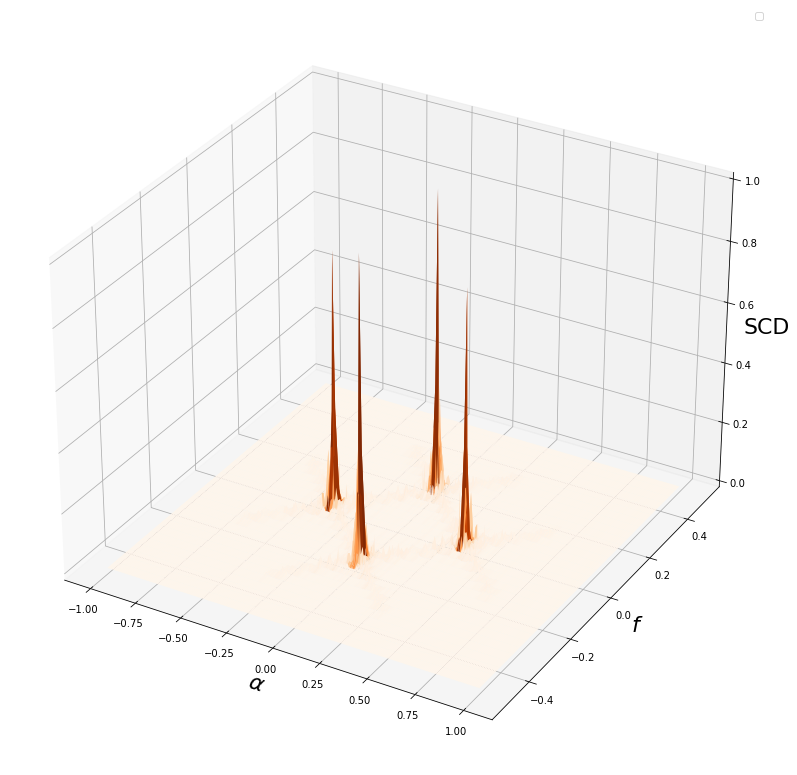

In [11]:
from matplotlib import cm

m = m / np.amax(m, axis=(1,2), keepdims=True)

X = np.linspace(-1., 1., num=int(m.shape[-1]))
Y = np.linspace(-0.5, 0.5, num=int(m.shape[-2]))
X, Y = np.meshgrid(X, Y)

for i in range(m.shape[0]):
    print ('>>>')
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(111, projection='3d')
    ax.legend()
    ax.set_ylabel(r'$f$', fontsize=22)
    ax.set_xlabel(r'$\alpha$',fontsize=22)
    ax.set_zlabel('SCD',fontsize=22)
    ax.plot_surface(X, Y, m[i,:,:], rstride = 4, cstride = 4, cmap='Oranges', antialiased=True)
    #ax.plot_trisurf(X, Y, m[i,:,:], cmap=cm.viridis)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


>>>


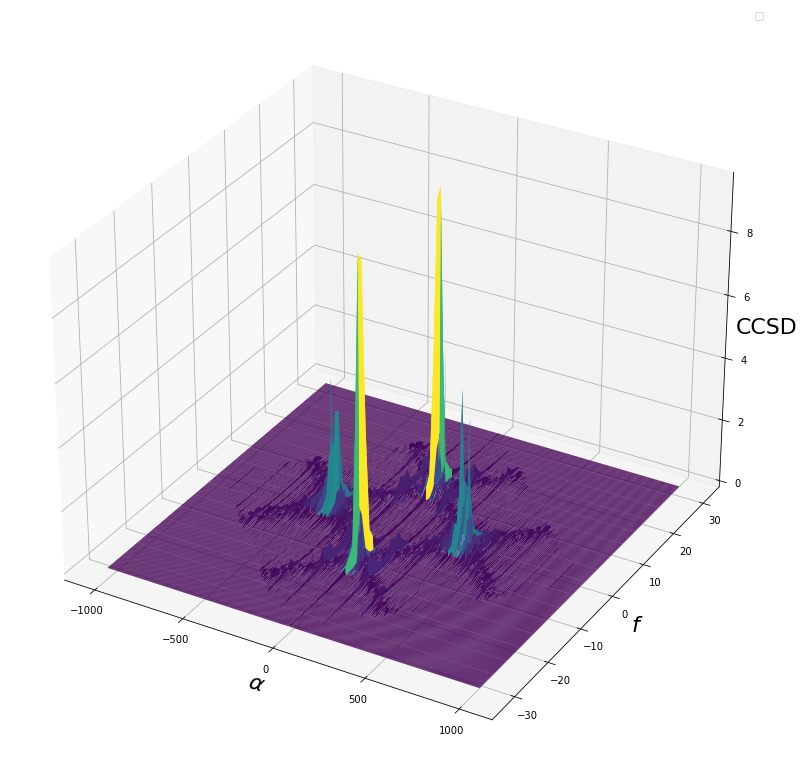

In [91]:
from matplotlib import cm


m = nn[:,0,:,:]

X = np.arange(-m.shape[-1]//2, m.shape[-1]//2)
Y = np.arange(-m.shape[-2]//2, m.shape[-2]//2)
X, Y = np.meshgrid(X, Y)

for i in range(m.shape[0]):
    print ('>>>')
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(111, projection='3d')
    ax.legend()
    ax.set_ylabel(r'$f$', fontsize=22)
    ax.set_xlabel(r'$\alpha$',fontsize=22)
    ax.set_zlabel('CCSD',fontsize=22)
    ax.plot_surface(X, Y, m[i,:,:], rstride = 4, cstride = 4, cmap=cm.viridis, antialiased=True)
    #ax.plot_trisurf(X, Y, m[i,:,:], cmap=cm.viridis)
    plt.show()

In [ ]:
from matplotlib import cm

m = nnn[:,0,:,:]

for i in range(m.shape[0]):
    print ('>>>')
    plt.figure(figsize=(10,10))
    plt.matshow(abs(m[i,:,:]), cmap='Oranges')
    plt.show()
    

## cumulants

In [ ]:
import numpy as np
import cupy as cp
import h5py


def cmf(s, p, q, window_size=L_, step=L_, neg=1.):
    
    L = s.shape[-1]
    wt = np.r_[1.:float(window_size+1)] #/ window_size
    al = np.linspace(-0.5, 0.5, num=int(window_size*2)) * neg
    
    m = p - q
    s = pow(s, m) * pow(np.conj(s), q)
    
    no = int(np.floor((L - window_size) / step)) + 1
    shape = (no, window_size)
    out = []
    #for i in s:
    #    strides = (i.strides[-1] * step, i.strides[-1])  # size block * window
    #    out.append(np.lib.stride_tricks.as_strided(i, shape=shape, strides=strides))
    #s = np.asarray(out)    # size n * block * window
    
    suanzi = cp.outer(cp.asarray(al), cp.asarray(wt))
    suanzi = cp.exp(2j*cp.pi*suanzi)  # size alpha * window
    #cmf = cp.einsum('nki,ji->nkj', cp.asarray(s), suanzi) / cp.asarray(window_size)
    cmf = cp.einsum('ni,ji->nj', cp.asarray(s), suanzi) / cp.asarray(window_size)
    #cmf = cp.matmul(cp.asarray(s), cp.transpose(suanzi, (1, 0))) / cp.asarray(window_size)
    #cmf = cp.mean(cmf, axis=1)
    del s, suanzi, out
    return np.asarray(cp.asnumpy(cmf), dtype=np.cfloat)


def RD_CTCF(s):
    
    L = s.shape[-1]
    s = np.asarray(s)
    a = s.real
    b = s.imag
    s = s / np.amax(np.sqrt(np.mean(a**2 + b**2, axis=-1, keepdims=True)))
    
    M20 = cmf(s, p=2, q=0)
    M21 = cmf(s, p=2, q=1)
    M21_= cmf(s, p=2, q=1)
    M22 = cmf(s, p=2, q=2)
    M40 = cmf(s, p=4, q=0)
    M41 = cmf(s, p=4, q=1)
    M42 = cmf(s, p=4, q=2)
    M43 = cmf(s, p=4, q=3)
    M61 = cmf(s, p=6, q=1)
    M63 = cmf(s, p=6, q=3)
    
    C40 = M40 - 2*M20*M22 - M20*M20
    C42 = M42 - M20*M22 - 2*M21*M21_
    C61 = M61 - 5*M21*M40 - 10*M20*M41 + 30*M20*M20*M21
    C63 = M63 - 9*M21*M42 - 3*M20*M43 - 3*M22*M41 + 18*M20*M21*M22 + 12*M21*M21*M21
    return np.stack((C40, C42, C61, C63)).transpose((1, 0, 2))

In [ ]:
hf = h5py.File('my_qam_SNR_inf.h5', 'r+')
nn = []
name = []

for k in hf.keys():
    o = []
    n, l = hf[k].shape
    print (k)
    o.append(RD_CTCF(hf[k][:1, :25600]))
    nn.append(o)
    name.append(k)
    
nn = np.asarray(nn)
print (nn.shape)
hf.close()


In [ ]:
#%matplotlib notebook
import h5py, pickle
import numpy as np
import numpy
import matplotlib.pyplot as plt

x_ticks = np.linspace(-0.5, 0.5, num=int(nn.shape[-1]))
print (name)

para = {'figure.figsize' : (12, 4), 
        'font.size'      : 22    }

plt.rcParams.update(para)
L = nn.shape[-1]
m = L//8

n = 0
for ii in abs(nn[0, 0, 0, 0, :]):
    if ii > 1.:
        nn[0, 0, 0, 0, n] = ii * 0.7
    n = n + 1

for i in range(nn.shape[0]):
    
    print (name[i], 'C40')
    plt.title(f'C_0_4_0 for {name[i]}')
    plt.ylim(0.0, 1.5)
    plt.plot(x_ticks, abs(nn[i, 0, 0, 0, :]))
    plt.show()
    
    print (name[i], 'C42')
    plt.ylim(0.0, 1.5)
    #draw, _ = envelope_extraction(abs(nn[i, 0, 0, 1, :]))
    plt.title(f'C_0_4_2 for {name[i]}')
    plt.plot(x_ticks, abs(nn[i, 0, 0, 1, :])*1.3)
    plt.show()
    
    print (name[i], 'C61')
    plt.title(f'C_0_6_1 for {name[i]}')
    plt.ylim(0.0, 5.)
    #nn[i, 0, 0, 2, 1700:3500] = nn[i, 0, 0, 2, 1700:3500]*0.3
    plt.plot(x_ticks, (abs(nn[i, 0, 0, 2, :])*0.5+abs(std)*0.1))
    plt.show()
    
    print (name[i], 'C63')    
    plt.title(f'C_0_6_3 for {name[i]}')
    plt.ylim(0.0, 5.)

    nn[i, 0, 0, 3, (L//2-m):(L//2+m)] = nn[i, 0, 0, 3, (L//2-m):(L//2+m)]*0.5
    plt.plot(x_ticks, (abs(nn[i, 0, 0, 3, :])))
    #plt.xlabel('Here, bit rate is 1.0')
    plt.show()


In [ ]:
std = nn[0, 0, 0, 3, :]

In [ ]:
#%matplotlib notebook
import h5py, pickle
import numpy as np
import numpy
import matplotlib.pyplot as plt

x_ticks = np.linspace(-1.5, 1.5, num=int(nn.shape[-1]))
print (name)
plt.rcParams["figure.figsize"]=12, 4

#i = 0
#for ii in abs(nn[0, 0, 0, 1, :]):
#    if ii > 0.8:
#        nn[0, 0, 0, 1, i] = ii / 4
#    i = i + 1

for i in range(nn.shape[0]):
    
    print (name[i], 'C40')
    plt.title(f'C_0_4_2 for {name[i]}')
    plt.ylim(0.0, 2.0)
    plt.plot(x_ticks, abs(nn[i, 0, 0, 0, :]))
    plt.show()
    
    print (name[i], 'C42')
    plt.ylim(0.0, 2.0)
    #draw, _ = envelope_extraction(abs(nn[i, 0, 0, 1, :]))
    plt.title(f'C_0_4_2 for {name[i]}')
    plt.plot(x_ticks, abs(nn[i, 0, 0, 1, :]))
    #my_y_ticks = np.arange(-2, 2, 0.3)
    plt.xlabel('Here, bit rate is 1.0')
    #plt.yticks(my_y_ticks)
    plt.show()
    
    print (name[i], 'C61')
    plt.plot(x_ticks, abs(nn[i, 0, 0, 2, :]))
    plt.show()
    
    print (name[i], 'C63')
    plt.plot(x_ticks, abs(nn[i, 0, 0, 3, :]))
    plt.show()
    